### Modules

In [1]:
# general 
import psycopg2 as psyc
import pandas as pd
import numpy as np
import json
import datetime
from collections import Counter

# statistics 
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import ttest_rel, bartlett, levene

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ETL

In [2]:
# saved database connection data as a hidden json file, for confidentiality 
with open("/Users/lucasramadan/SCL-Work/.db_conn.json", 'r') as f:
    db_conn = json.load(f)

In [3]:
# create the connection
# unpacking the arguments
conn = psyc.connect(**db_conn)

In [4]:
cur = conn.cursor()

In [5]:
# query to gather metrics 
with open('/Users/lucasramadan/SCL-Work/LA_Same-Day_Zip_Experiment/travel_time_metrics_array.sql') as f:
    q = f.read()

In [6]:
cur.execute(q)

In [7]:
data = cur.fetchall()

In [8]:
data = np.asarray(data)

In [9]:
cols = [col.name for col in cur.description]
cols

['visit_date', 'zone', 'vtt', 'ptt', 'pttpv', 'ttt']

In [10]:
# finally close the connection
conn.close()

In [11]:
df = pd.DataFrame(data[:, 1:], index=data[:, 0], columns=cols[1:])
df.fillna(value=0.0)
df.head()

,zone,vtt,ptt,pttpv,ttt
2016-09-26,LA-A,"[22.66583335, 30.3299999992, 26.6041666667, 19...","[5.0, 5.08500001828, 5.0, 30.0, 45.6724999984,...","[0.714285714286, 0.635625002285, 0.71428571428...","[23.3801190643, 30.9656250015, 27.318452381, 2..."
2016-09-27,LA-A,"[21.0791666667, 20.9941666842, 29.1400000016, ...","[66.8941666842, 86.7700000008, 5.0, 5.08500001...","[6.68941666842, 10.8462500001, 2.5, 0.63562500...","[27.7685833351, 31.8404166842, 31.6400000016, ..."
2016-09-28,LA-A,"[43.3666666667, 18.7, 33.8008333325, 26.516666...","[86.7700000008, 36.1808333317, 86.7700000008, ...","[10.8462500001, 4.02009259242, 10.8462500001, ...","[54.2129166668, 22.7200925924, 44.6470833326, ..."
2016-09-29,LA-A,"[28.0166666667, 28.1, 57.8841666659, 15.45, 45...","[56.2833333333, 33.4041666667, 5.0, 1.0, 66.89...","[11.2566666667, 8.35104166667, 0.833333333333,...","[39.2733333333, 36.4510416667, 58.7174999992, ..."
2016-09-30,LA-A,"[52.0, 47.0666666667, 35.65, 35.65]","[49.7383333325, 63.4658333341, 63.4658333341, ...","[5.52648148139, 7.93322916677, 7.93322916677, ...","[57.5264814814, 54.9998958334, 43.5832291668, ..."


### Filtering and Segmentation

In [12]:
test_date = datetime.date(2016, 11, 10)

In [13]:
df = df[df.index < datetime.date.today()]

In [14]:
before = df.copy().drop('zone', axis=1)
before = before[before.index < test_date]
before.head()

,vtt,ptt,pttpv,ttt
2016-09-26,"[22.66583335, 30.3299999992, 26.6041666667, 19...","[5.0, 5.08500001828, 5.0, 30.0, 45.6724999984,...","[0.714285714286, 0.635625002285, 0.71428571428...","[23.3801190643, 30.9656250015, 27.318452381, 2..."
2016-09-27,"[21.0791666667, 20.9941666842, 29.1400000016, ...","[66.8941666842, 86.7700000008, 5.0, 5.08500001...","[6.68941666842, 10.8462500001, 2.5, 0.63562500...","[27.7685833351, 31.8404166842, 31.6400000016, ..."
2016-09-28,"[43.3666666667, 18.7, 33.8008333325, 26.516666...","[86.7700000008, 36.1808333317, 86.7700000008, ...","[10.8462500001, 4.02009259242, 10.8462500001, ...","[54.2129166668, 22.7200925924, 44.6470833326, ..."
2016-09-29,"[28.0166666667, 28.1, 57.8841666659, 15.45, 45...","[56.2833333333, 33.4041666667, 5.0, 1.0, 66.89...","[11.2566666667, 8.35104166667, 0.833333333333,...","[39.2733333333, 36.4510416667, 58.7174999992, ..."
2016-09-30,"[52.0, 47.0666666667, 35.65, 35.65]","[49.7383333325, 63.4658333341, 63.4658333341, ...","[5.52648148139, 7.93322916677, 7.93322916677, ...","[57.5264814814, 54.9998958334, 43.5832291668, ..."


In [15]:
after = df[df.index >= test_date]
after = after[after['zone'] == 'LA-A']
after.drop('zone', axis=1, inplace=True)
after.head()

,vtt,ptt,pttpv,ttt
2016-11-10,"[57.95, 23.7666666667]","[35.7700000008, 35.7700000008]","[17.8850000004, 17.8850000004]","[75.8350000004, 41.6516666671]"
2016-11-11,"[5.36833335161, 23.7666666667]","[5.0, 5.58083335161]","[2.5, 1.11616667032]","[7.86833335161, 24.882833337]"
2016-11-12,"[38.6833333333, 38.6833333333]","[5.58083335161, 45.0]","[0.930138891935, 7.5]","[39.6134722253, 46.1833333333]"
2016-11-13,"[30.4666666667, 20.8333333333]","[5.43916668495, 5.0]","[0.543916668495, 1.66666666667]","[31.0105833352, 22.5]"
2016-11-14,[31.8333333333],[5.0],[0.5],[32.3333333333]


In [16]:
before_samp = before.applymap(np.mean)
before_samp.head()

,vtt,ptt,pttpv,ttt
2016-09-26,25.543333,26.855758,7.469410,33.012744
2016-09-27,30.230833,31.926111,4.495424,34.726257
2016-09-28,32.475119,51.789286,13.801948,46.277067
2016-09-29,35.611771,35.788854,5.708305,41.320076
2016-09-30,42.591667,52.539792,6.544277,49.135943


In [17]:
after_samp = after.applymap(np.mean)
after_samp.head()

,vtt,ptt,pttpv,ttt
2016-11-10,40.858333,35.770000,17.885000,58.743333
2016-11-11,14.567500,5.290417,1.808083,16.375583
2016-11-12,38.683333,25.290417,4.215069,42.898403
2016-11-13,25.650000,5.219583,1.105292,26.755292
2016-11-14,31.833333,5.000000,0.500000,32.333333


### Aggregate Samples and Daily Sample Means

In [18]:
# without sample means, IE in aggregate
vtt = [reduce(lambda x,y: x+y, before['vtt'].values), reduce(lambda x,y: x+y, after['vtt'].values)]
ptt = [reduce(lambda x,y: x+y, before['ptt'].values), reduce(lambda x,y: x+y, after['ptt'].values)]
pttpv = [reduce(lambda x,y: x+y, before['pttpv'].values), reduce(lambda x,y: x+y, after['pttpv'].values)]
ttt = [reduce(lambda x,y: x+y, before['ttt'].values), reduce(lambda x,y: x+y, after['ttt'].values)]

In [19]:
# sample means, for normality 
vtt_samp = [before_samp['vtt'].values, after_samp['vtt'].values]
ptt_samp = [before_samp['ptt'].values, after_samp['ptt'].values]
pttpv_samp = [before_samp['pttpv'].values, after_samp['pttpv'].values]
ttt_samp = [before_samp['ttt'].values, after_samp['ttt'].values]

### Visit Travel Time

#### Aggregate

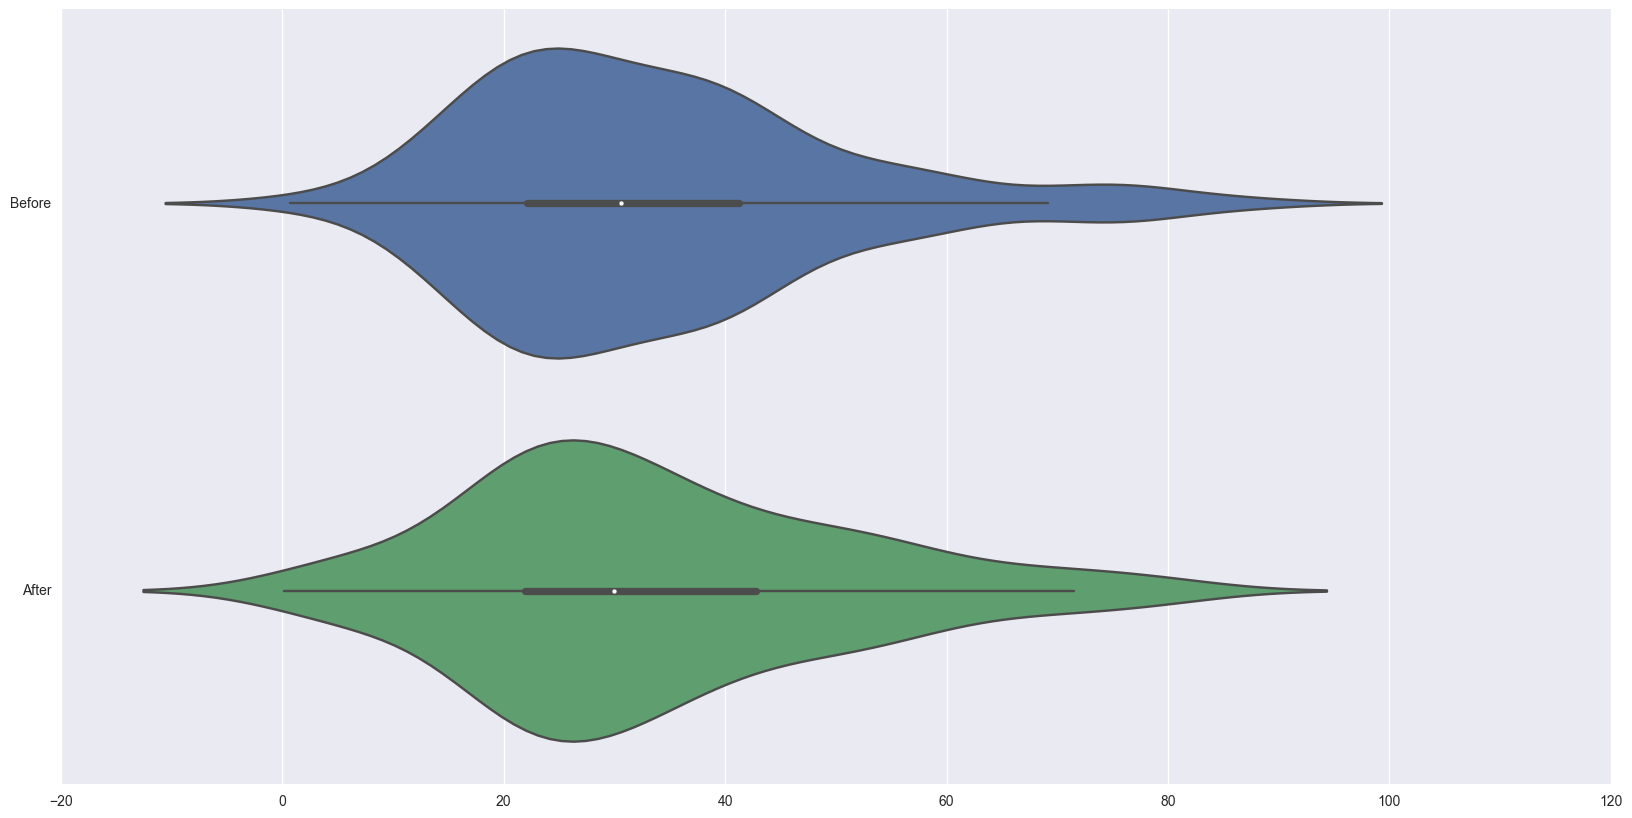

In [20]:
plt.figure(figsize=(20,10))
sns.violinplot(data=vtt, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

#### Daily Sample means

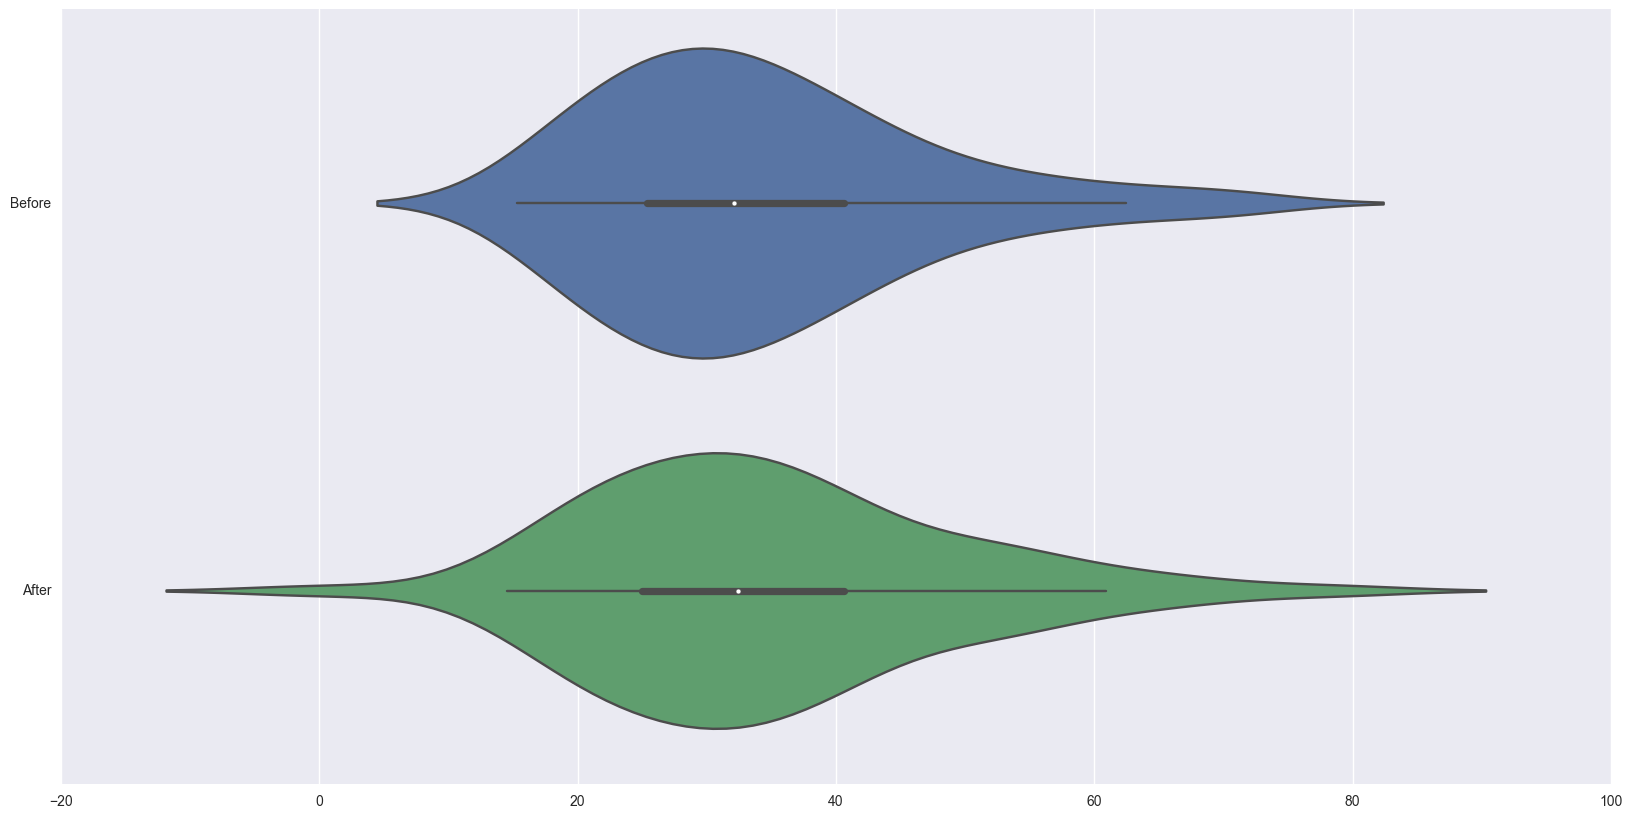

In [21]:
# ptt
plt.figure(figsize=(20,10))
plt.ylim([-20, 200])
sns.violinplot(data=vtt_samp, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

### Pickup Travel Time

#### Aggregate

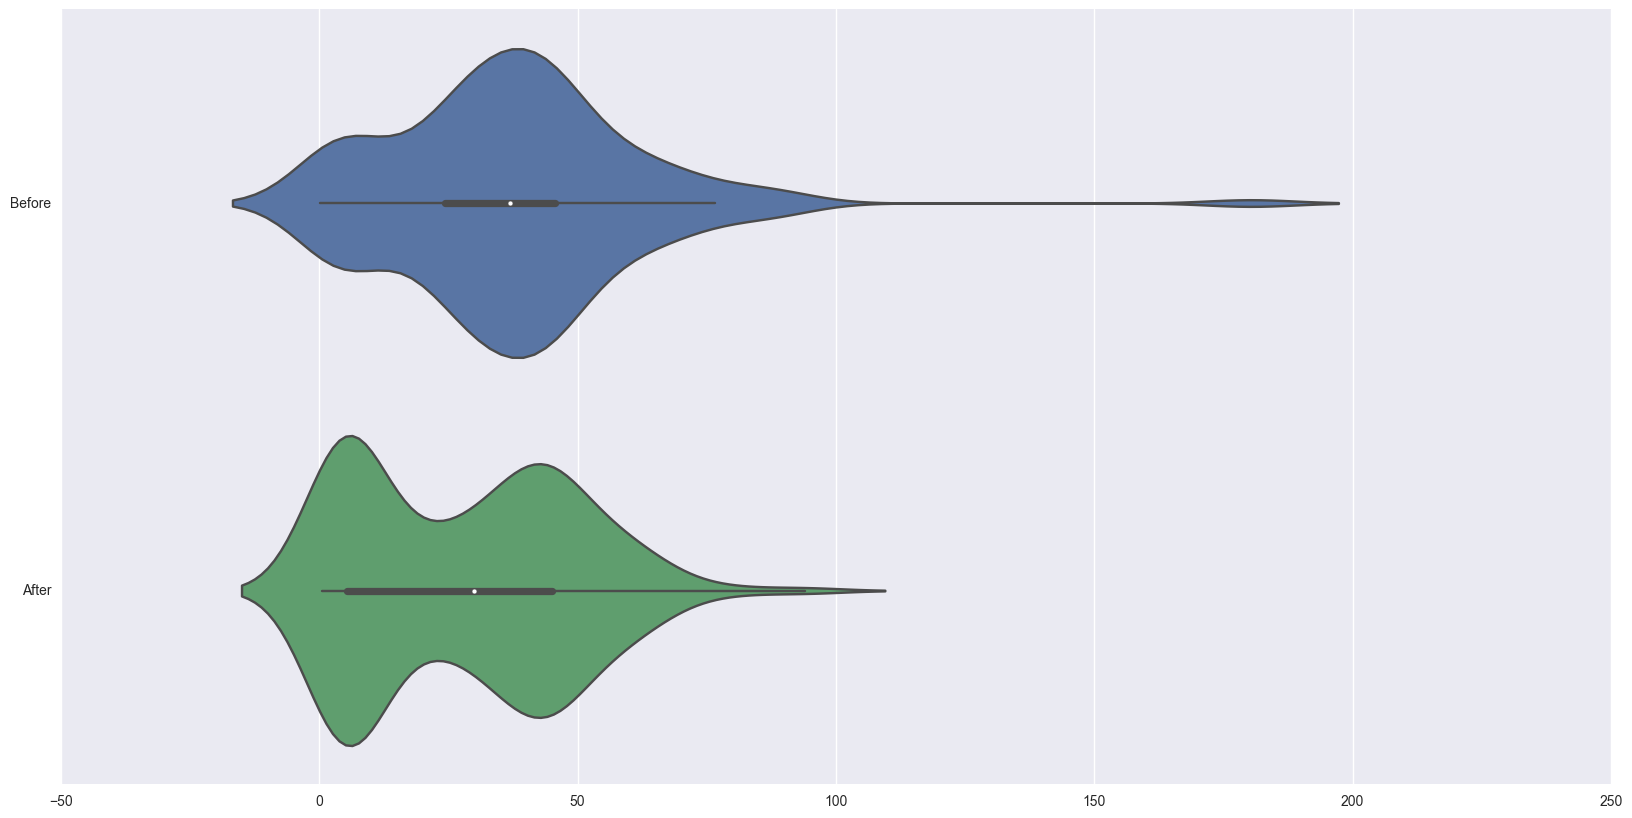

In [22]:
plt.figure(figsize=(20,10))
plt.ylim([-20, 200])
sns.violinplot(data=ptt, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

#### Daily Sample Means

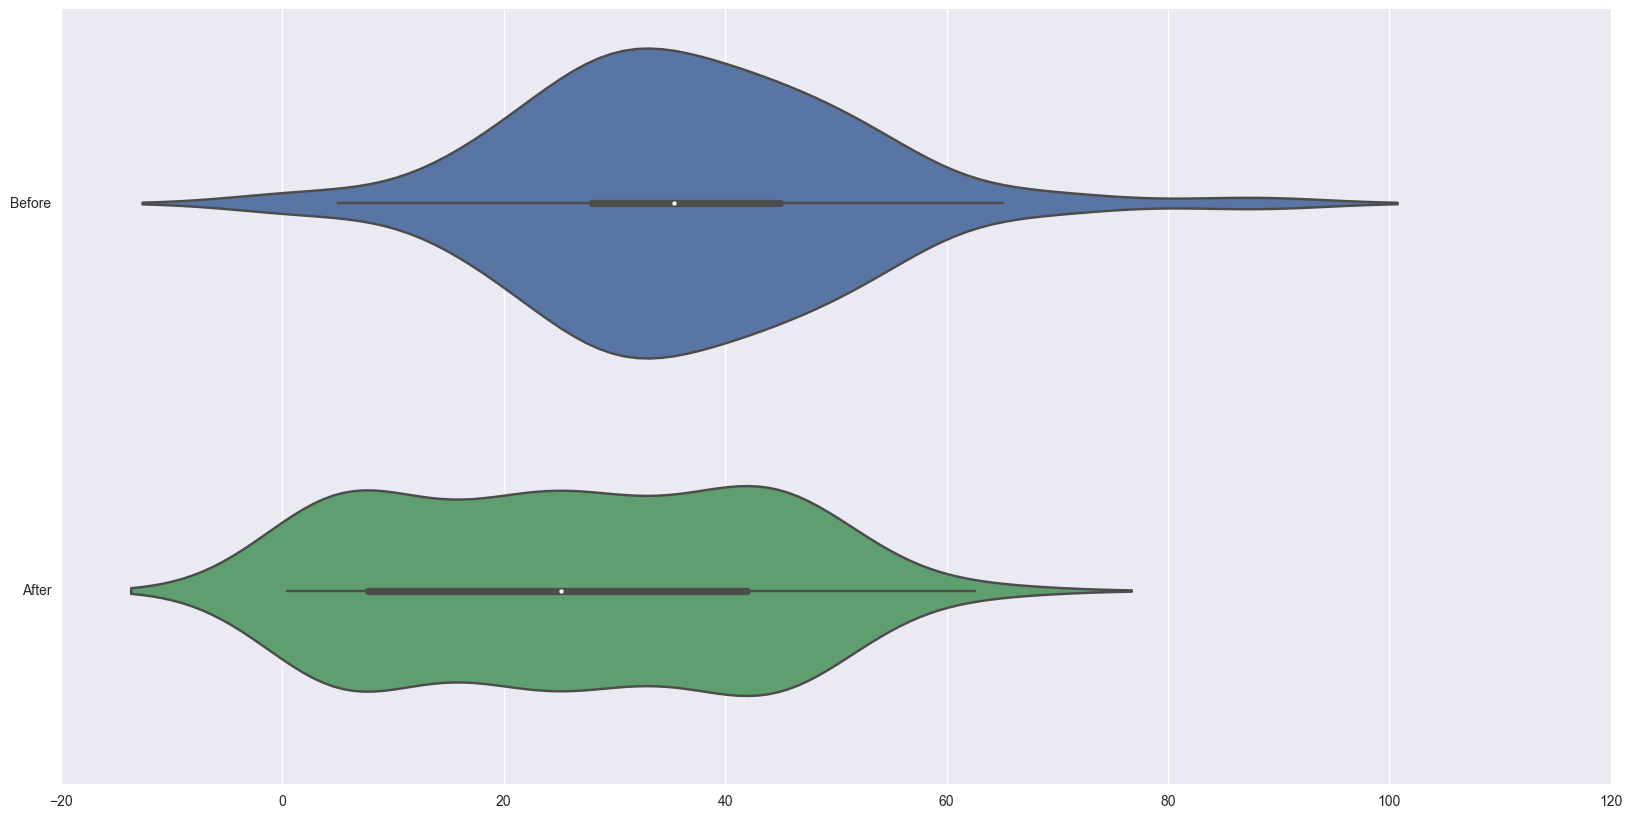

In [23]:
# ppt
plt.figure(figsize=(20,10))
plt.ylim([0, 100])
sns.violinplot(data=ptt_samp, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

### Pickup Travel Time per Visit

#### Aggregate

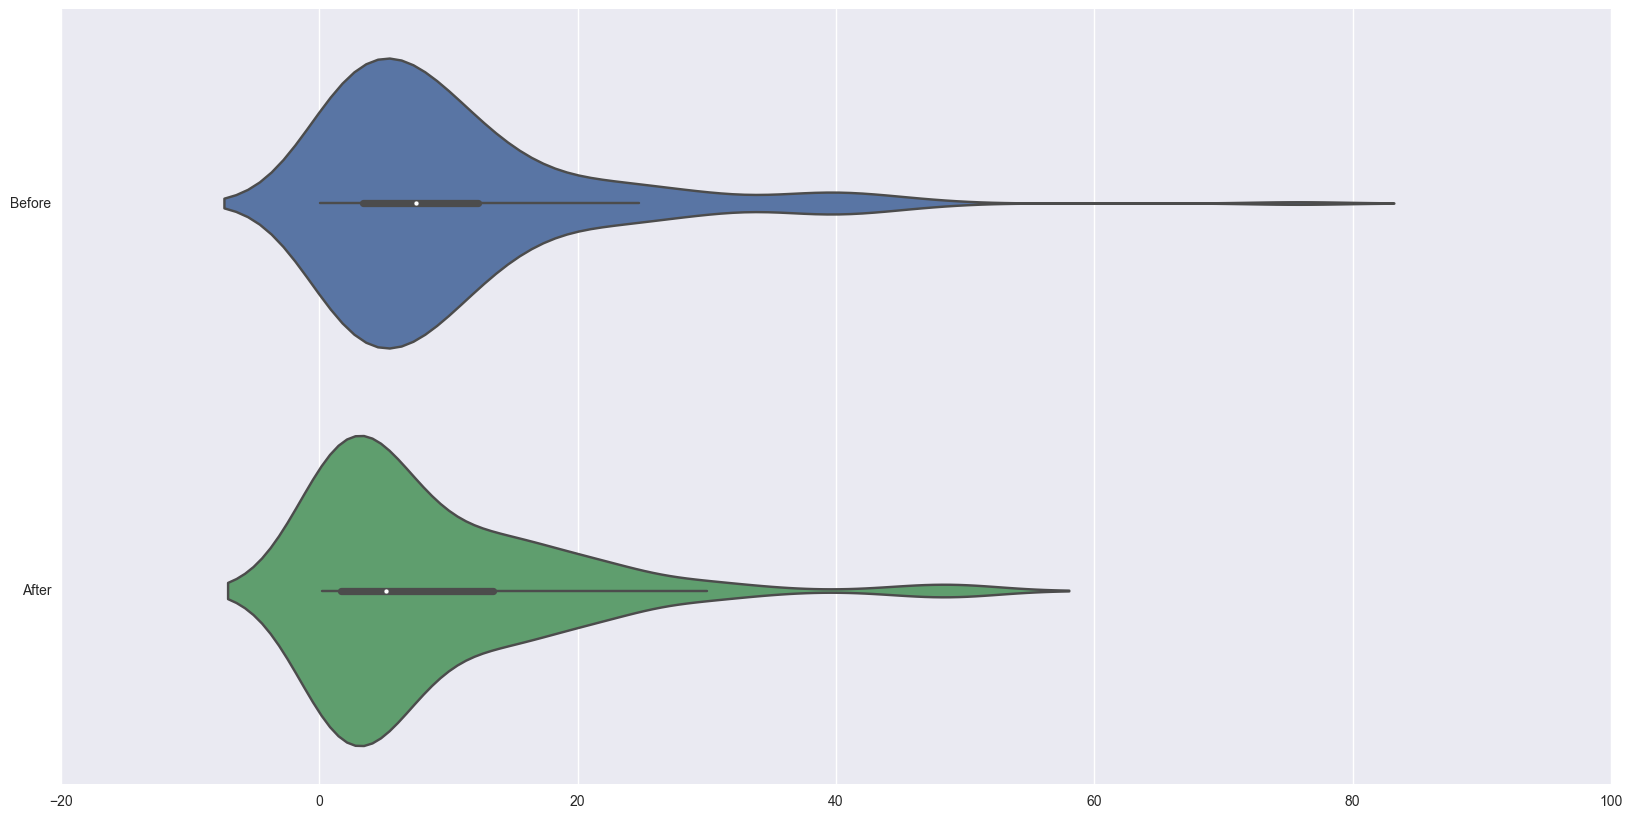

In [24]:
plt.figure(figsize=(20,10))
sns.violinplot(data=pttpv, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

#### Daily Sample Means

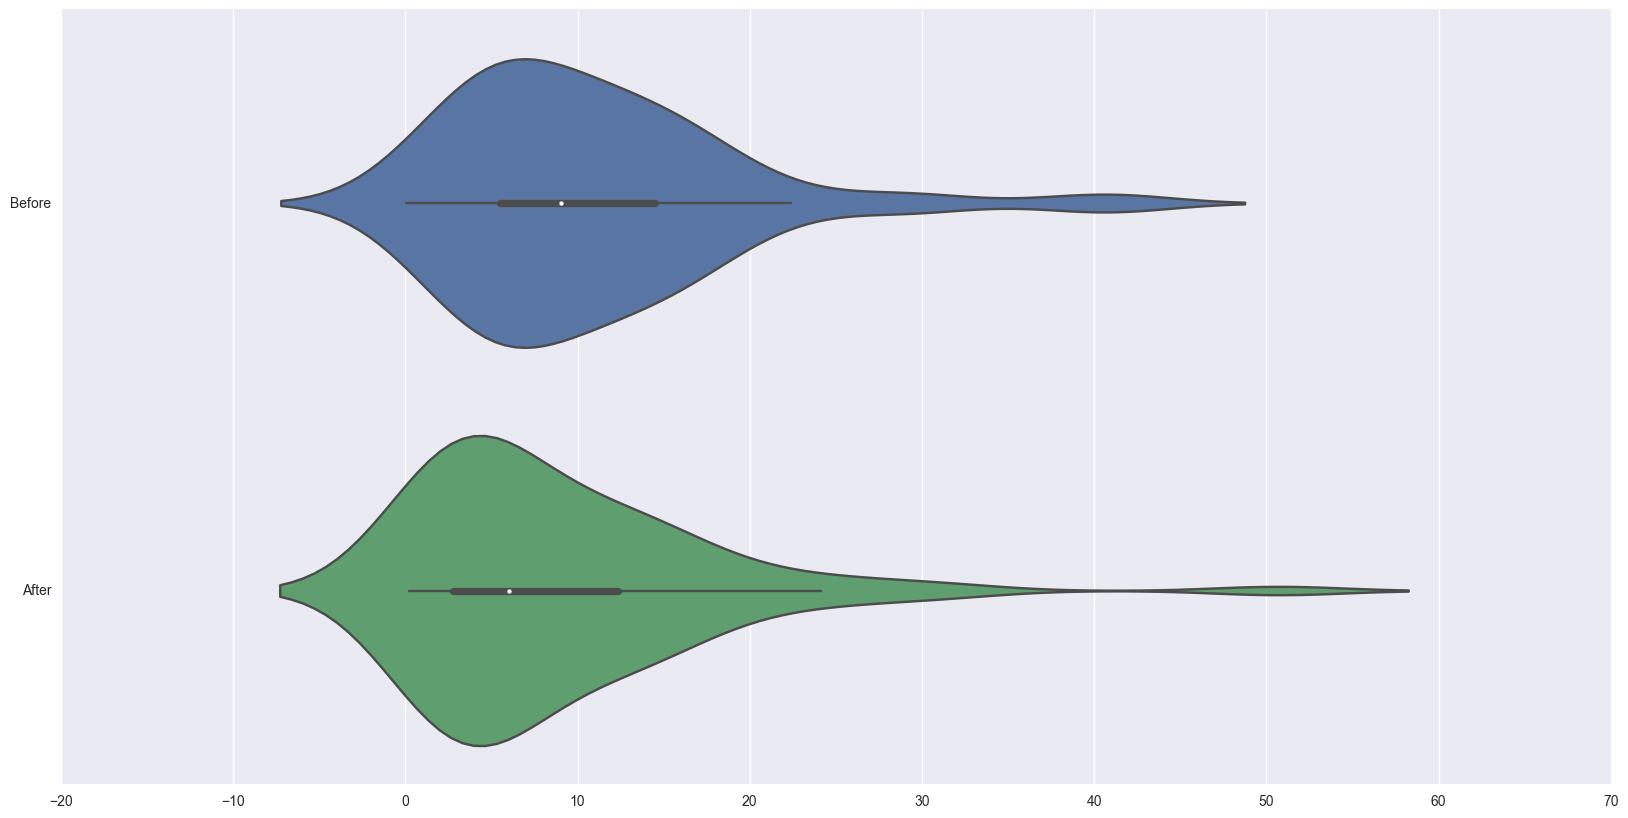

In [25]:
plt.figure(figsize=(20,10))
sns.violinplot(data=pttpv_samp, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

### Total Travel Time

#### Aggregate

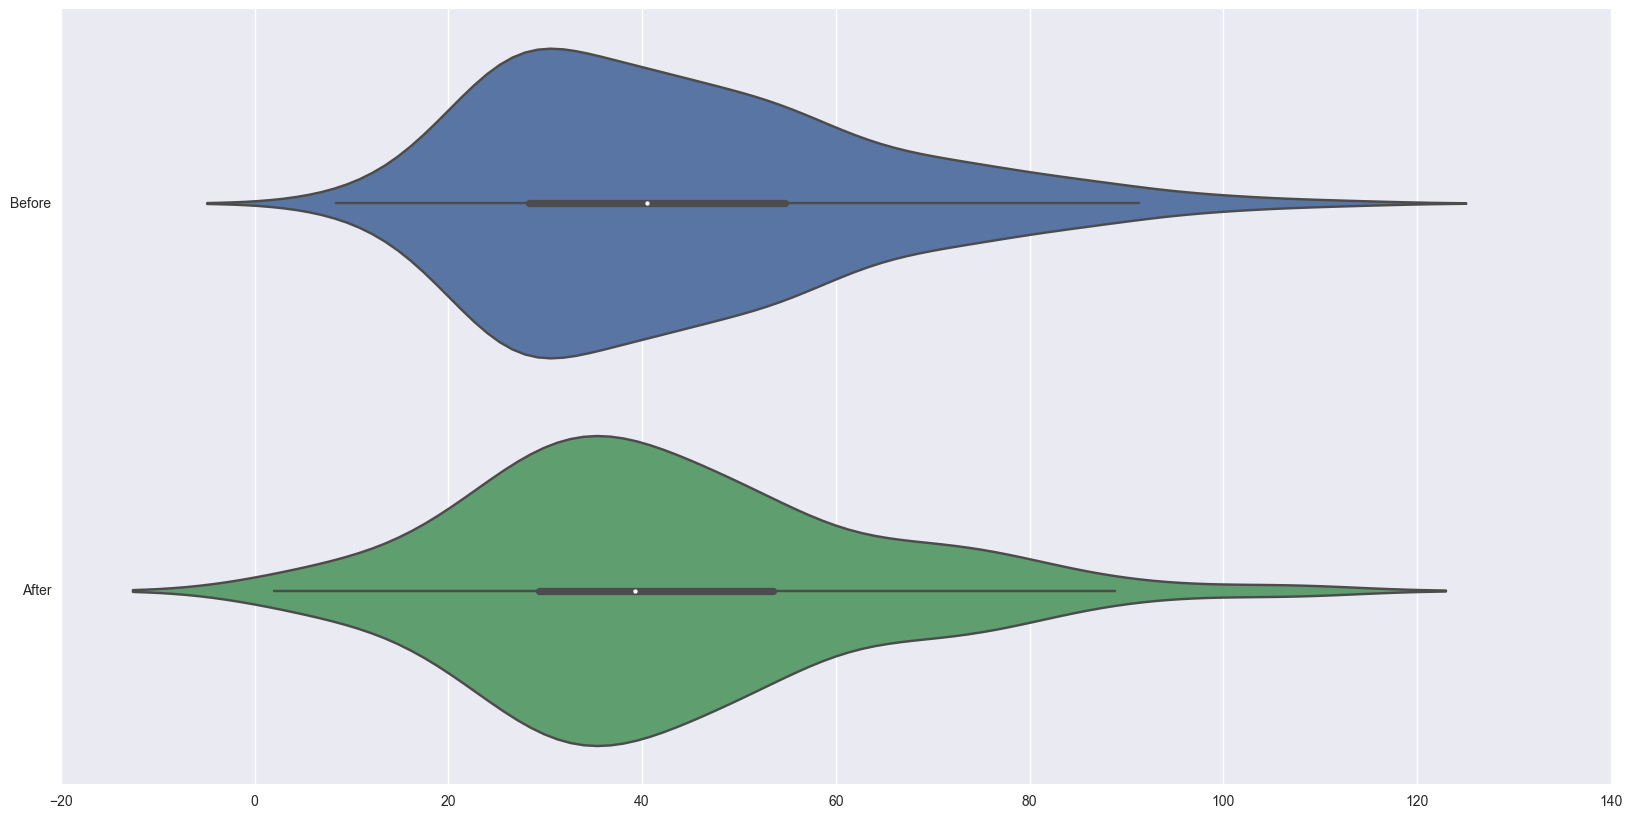

In [26]:
plt.figure(figsize=(20,10))
sns.violinplot(data=ttt, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

#### Daily Sample Means

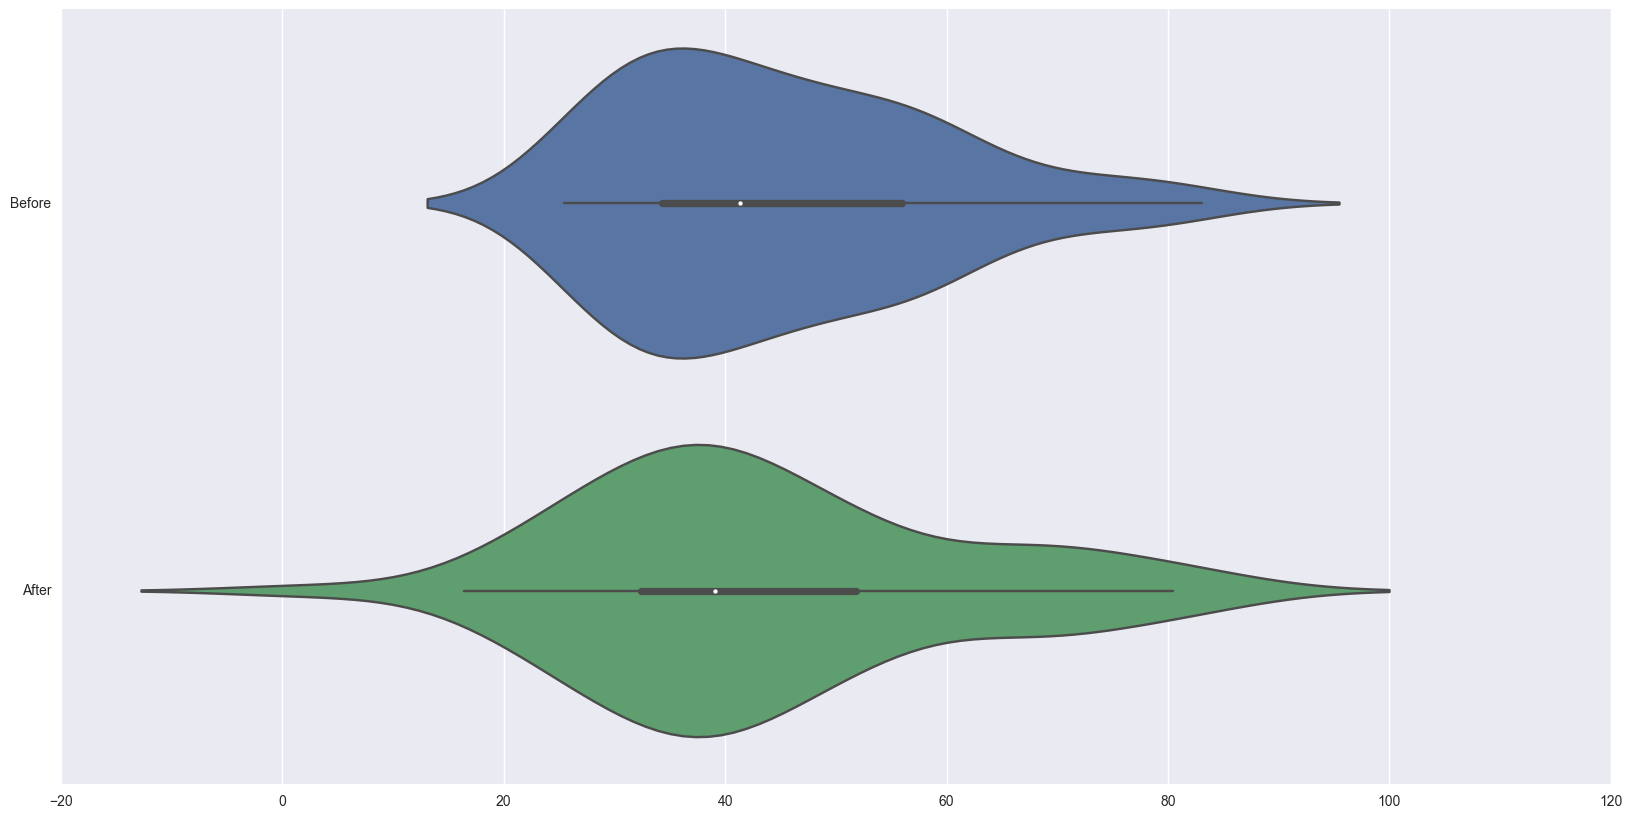

In [27]:
plt.figure(figsize=(20,10))
sns.violinplot(data=ttt_samp, orient='h')
plt.yticks([0, 1], ['Before', 'After'])
plt.show();

### Statistical Analysis

#### Aggregate, High Level

In [28]:
# high level summary
# before, after
# mean, median, stdev

print 'vtt'
print '-'*40
print 'means:', map(np.mean, vtt)
print 'medians:', map(np.median, vtt)
print 'stdevs:', map(np.std, vtt)
print '-'*40
print 'ptt'
print 'means:', map(np.mean, ptt)
print 'medians:', map(np.median, ptt)
print 'stdevs:', map(np.std, ptt)
print '-'*40
print 'pttpv'
print 'means:', map(np.mean, pttpv)
print 'medians:', map(np.median, pttpv)
print 'stdevs:', map(np.std, pttpv)
print '-'*40
print 'ttt'
print 'means:', map(np.mean, ttt)
print 'medians:', map(np.median, ttt)
print 'stdevs:', map(np.std, ttt)
print '-'*40

vtt
----------------------------------------
means: [33.758872094172844, 33.581812771883875]
medians: [30.570833333333301, 30.0]
stdevs: [16.494758988411412, 17.327597648032011]
----------------------------------------
ptt
means: [37.57081395607586, 28.001428576542697]
medians: [37.016666666666701, 30.0]
stdevs: [24.733657539925577, 21.127456448076853]
----------------------------------------
pttpv
means: [10.349622820346625, 8.9210854032138549]
medians: [7.5, 5.1529166758060452]
stdevs: [10.825436785662593, 9.9839786010387463]
----------------------------------------
ttt
means: [44.108494914519454, 42.502898175097734]
medians: [40.508541665474603, 39.257500020662945]
stdevs: [19.421196953789881, 19.998936717834965]
----------------------------------------


In [29]:
summary = []

# always [before, after] for each metric

for metric in [vtt, ptt, pttpv, ttt]:
    
    # ie compare before (0) and after (1)
    stats = ttest_ind(metric[0], metric[1], usevar='unequal')
    
    summary.append(stats)

In [30]:
summary = pd.DataFrame(summary, index=['vtt', 'ptt', 'pttpv', 'ttt'], columns=['t-score', 'p-value', 'df'])
summary.head()

,t-score,p-value,df
vtt,0.098461,0.921628,319.569341
ptt,3.981680,0.000083,355.621083
pttpv,1.304549,0.192918,344.359096
ttt,0.767478,0.443357,323.672404


#### Daily Sample Means

In [31]:
# high level summary
# before, after
print 'vtt:'
print map(np.mean, vtt_samp), map(np.median, vtt_samp), map(np.std, vtt_samp)
print 'ptt:'
print map(np.mean, ptt_samp), map(np.median, ptt_samp), map(np.std, ptt_samp)
print 'pttpv:'
print map(np.mean, pttpv_samp), map(np.median, pttpv_samp), map(np.std, pttpv_samp)
print 'ttt:'
print map(np.mean, ttt_samp), map(np.median, ttt_samp), map(np.std, ttt_samp)

vtt:
[34.251784397750342, 34.6964883039632] [32.133988101331013, 32.438888888888904] [12.388615334596835, 13.911932565053306]
ptt:
[36.616007856345078, 26.107361106608781] [35.406354173024503, 25.141666666666666] [14.658673720576685, 16.274133956720686]
pttpv:
[10.840900106754322, 8.8514323608449867] [9.0591154117072339, 6.0095238095238095] [8.2844887459964998, 8.6468347392979119]
ttt:
[45.09268450450466, 43.547920664808188] [41.335767072474681, 39.100000035762797] [14.088482888822533, 17.037309129494542]


In [32]:
summary_samp = []

# always [before, after] for each metric

for metric in [vtt_samp, ptt_samp, pttpv_samp, ttt_samp]:
    
    # ie compare before (0) and after (1)
    stats = ttest_ind(metric[0], metric[1], usevar='unequal')
    
    summary_samp.append(stats)

In [33]:
summary_samp = pd.DataFrame(summary_samp, index=['vtt', 'ptt', 'pttpv', 'ttt'], columns=['t-score', 'p-value', 'df'])
summary_samp.head()

,t-score,p-value,df
vtt,-0.191929,0.848101,128.385082
ptt,3.856915,0.000181,128.569488
pttpv,1.334566,0.184369,128.998224
ttt,0.562250,0.574941,126.448814


#### Analysis of Variance

In [34]:
# checking for variances
var_summary = []

agg_data = [['vtt', vtt], ['ptt', ptt], ['pttpv', pttpv], ['ttt', ttt]]

var_cols = ['Bartlet Stat', 'Bartlet p', 'Levene Stat', 'Levene p']

for met_name, (before, after) in agg_data:
    
    # ie compare before (0) and after (1)
    b = bartlett(before, after)
    l = levene(before, after)
    
    var_summary.append([met_name, b.statistic, b.pvalue, l.statistic, l.pvalue])
    
var_summary = np.asarray(var_summary)
var_summary = pd.DataFrame(var_summary[:, 1:], index=var_summary[:, 0], columns=var_cols)
var_summary

,Bartlet Stat,Bartlet p,Levene Stat,Levene p
vtt,0.450417209977,0.50213689457,0.457059503624,0.499427237681
ptt,4.27565015239,0.0386621705565,1.03247385005,0.310247730833
pttpv,1.12728988145,0.288354151145,0.0517829757151,0.820116023694
ttt,0.163233021826,0.686197228165,1.93867488301e-05,0.996489287176


In [35]:
# checking for variances
var_summary_samp = []

agg_data_samp = [['vtt', vtt_samp], ['ptt', ptt_samp], ['pttpv', pttpv_samp], ['ttt', ttt_samp]]

var_cols = ['Bartlet Stat', 'Bartlet p', 'Levene Stat', 'Levene p']

for met_name, (before, after) in agg_data_samp:
    
    # ie compare before (0) and after (1)
    b = bartlett(before, after)
    l = levene(before, after)
    
    var_summary_samp.append([met_name, b.statistic, b.pvalue, l.statistic, l.pvalue])
    
var_summary_samp = np.asarray(var_summary_samp)
var_summary_samp = pd.DataFrame(var_summary_samp[:, 1:], index=var_summary_samp[:, 0], columns=var_cols)
var_summary_samp

,Bartlet Stat,Bartlet p,Levene Stat,Levene p
vtt,0.85162310359,0.356093574831,0.565530310089,0.453410472335
ptt,0.692043621596,0.405470137914,3.17960366659,0.0769144859522
pttpv,0.115178783588,0.734323484095,0.00448182919877,0.946727970029
ttt,2.28148754126,0.130926246494,0.727957991601,0.395127329272


In [120]:
# summary.to_csv('/Users/lucasramadan/SCL-Work/LA_Same-Day_Zip_Experiment/summary_stats.csv')